# Models Evaluation

In [1]:
import numpy as np
from keras import backend as K
import scipy
from skimage.measure import label, regionprops
from skimage.transform import resize
import os
from PIL import Image
from keras.preprocessing import image
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import random
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
input_size = 224

In [3]:
# Define helper functions
def mk_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

def return_list(data_path, data_type):
    file_list = [file for file in os.listdir(data_path) if file.lower().endswith(data_type)]
    print(str(len(file_list)))
    return file_list

def train_loader(data_list, data_path, mask_path, input_size):
    for lineIdx in range(len(data_list)):
        temp_txt = data_list[lineIdx]

        train_img = np.asarray(image.load_img(
            os.path.join(data_path, temp_txt),
            target_size=(input_size, input_size, 3))
        ).astype('float32')

        img_mask = np.asarray(image.load_img(
            os.path.join(mask_path, temp_txt),
            target_size=(input_size, input_size, 3))) / 255.0

        img_mask = img_mask.astype('float32')

        yield (train_img, (img_mask, img_mask, img_mask, img_mask, img_mask))


def tf_data_loader(data_list, data_path, mask_path, input_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: train_loader(data_list, data_path, mask_path, input_size),
        output_signature=(
            tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32),
            tuple([tf.TensorSpec(shape=(input_size, input_size, 3), dtype=tf.float32)] * 5)
        )
    )
    return dataset

def pro_process(temp_img, input_size):
    img = np.asarray(temp_img).astype('float32')  # Ensure float32 dtype
    img = resize(img, (input_size, input_size, 3), preserve_range=True)  # Resize and preserve range
    return img

def BW_img(input, thresholding):
    if input.max() > thresholding:
        binary = input > thresholding
    else:
        binary = input > input.max()/2.0

    label_image = label(binary)
    regions = regionprops(label_image)
    area_list = []
    for region in regions:
        area_list.append(region.area)
    if area_list:
        idx_max = np.argmax(area_list)
        binary[label_image != idx_max+1] = 0
    return scipy.ndimage.binary_fill_holes(np.asarray(binary).astype(int))
    
def disc_crop(org_img, DiscROI_size, C_x, C_y):
    tmp_size = int(DiscROI_size/2)
    disc_region = np.zeros((DiscROI_size, DiscROI_size, 3), dtype= org_img.dtype)
    crop_coord = np.array([C_x-tmp_size, C_x+tmp_size, C_y-tmp_size, C_y+tmp_size], dtype= int)
    err_coord = [0, DiscROI_size, 0, DiscROI_size]

    if crop_coord[0] < 0:
        err_coord[0] = abs(crop_coord[0])
        crop_coord[0] = 0

    if crop_coord[2] < 0:
        err_coord[2] = abs(crop_coord[2])
        crop_coord[2] = 0

    if crop_coord[1] > org_img.shape[0]:
        err_coord[1] = err_coord[1] - (crop_coord[1] - org_img.shape[0])
        crop_coord[1] = org_img.shape[0]

    if crop_coord[3] > org_img.shape[1]:
        err_coord[3] = err_coord[3] - (crop_coord[3] - org_img.shape[1])
        crop_coord[3] = org_img.shape[1]

    disc_region[err_coord[0]:err_coord[1], err_coord[2]:err_coord[3], ] = org_img[crop_coord[0]:crop_coord[1], crop_coord[2]:crop_coord[3], ]

    return disc_region, err_coord, crop_coord

In [4]:
# Training Settings
result_path = mk_dir('/kaggle/working/output_deep_model/')
pre_model_file = '/kaggle/input/deep-model/deep_model/Model_MNet_REFUGE.h5'
save_model_file = result_path + 'Model_MNet_REFUGE_v2.keras'

root_path = '/kaggle/input/training-data-polar/training_crop/'
train_data_path = root_path + 'data/'
train_mask_path = root_path + 'label/'

val_data_path = root_path + 'val_data/data/'
val_mask_path = root_path + 'val_data/label/'

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

1400
300


In [5]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import  BatchNormalization, Activation, average

def Original_Model(size_set = 800):

    img_input = Input(shape=(size_set, size_set, 3))
    
    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu',name='block1_conv1')(img_input)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu',name='block1_conv2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    input2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_input1')(scale_img_2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_conv1')(input2)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block2_conv2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    input3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_input1')(scale_img_3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_conv1')(input3)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block3_conv2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    input4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_input1')(scale_img_4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_conv1')(input4)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block4_conv2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu',name='block5_conv1')(pool4)
    conv5 = Conv2D(512, (3, 3), padding='same', activation='relu',name='block5_conv2')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block6_conv1')(up6)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu',name='block6_conv2')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block7_conv1')(up7)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu',name='block7_conv2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu',name='block8_conv1')(up8)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu', name='block8_conv2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv1')(up9)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu', name='block9_conv2')(conv9)

    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)

    out10 = average([out6, out7, out8, out9])

    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10])

    return model

origin_model = Original_Model(size_set=input_size)
origin_model.load_weights('/kaggle/input/mnetrefugemodel-weights/Model_MNet_REFUGE_v2.keras')

In [6]:
def attention_gate(x, g, inter_channels):
    # x: Input feature map from the encoder (skip connection)
    # g: Gating signal from the decoder
    # inter_channels: Number of filters for intermediate computations

    theta_x = Conv2D(inter_channels, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(g)
    add = Add()([theta_x, phi_g])
    relu = Activation('relu')(add)
    psi = Conv2D(1, (1, 1), padding='same')(relu)
    sigmoid = Activation('sigmoid')(psi)
    upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(sigmoid)
    attn_coefficients = Multiply()([x, upsampled])
    return attn_coefficients

def Att_Model(size_set=800):

    img_input = Input(shape=(size_set, size_set, 3))

    # Scaled inputs
    scale_img_2 = AveragePooling2D(pool_size=(2, 2))(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2))(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2))(scale_img_3)

    # Block 1
    conv1 = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    input2 = Conv2D(64, (3, 3), padding='same', name='block2_input1')(scale_img_2)
    input2 = BatchNormalization()(input2)
    input2 = Activation('relu')(input2)
    input2 = concatenate([input2, pool1], axis=3)
    conv2 = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(input2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    input3 = Conv2D(128, (3, 3), padding='same', name='block3_input1')(scale_img_3)
    input3 = BatchNormalization()(input3)
    input3 = Activation('relu')(input3)
    input3 = concatenate([input3, pool2], axis=3)
    conv3 = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(input3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    input4 = Conv2D(256, (3, 3), padding='same', name='block4_input1')(scale_img_4)
    input4 = BatchNormalization()(input4)
    input4 = Activation('relu')(input4)
    input4 = concatenate([input4, pool3], axis=3)
    conv4 = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(input4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # Decoder with Attention Gates
    # Up Block 6
    attn4 = attention_gate(conv4, conv5, inter_channels=256)
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5)
    up6 = concatenate([up6, attn4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same', name='block6_conv1')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same', name='block6_conv2')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    # Up Block 7
    attn3 = attention_gate(conv3, conv6, inter_channels=128)
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6)
    up7 = concatenate([up7, attn3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', name='block7_conv1')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same', name='block7_conv2')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Up Block 8
    attn2 = attention_gate(conv2, conv7, inter_channels=64)
    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7)
    up8 = concatenate([up8, attn2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same', name='block8_conv1')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same', name='block8_conv2')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    # Up Block 9
    attn1 = attention_gate(conv1, conv8, inter_channels=32)
    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8)
    up9 = concatenate([up9, attn1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same', name='block9_conv1')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same', name='block9_conv2')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # Side Outputs with 1 channel each
    side6 = UpSampling2D(size=(8, 8))(conv6)
    side7 = UpSampling2D(size=(4, 4))(conv7)
    side8 = UpSampling2D(size=(2, 2))(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)
    
    # Final Output with name 'final_output'
    out10 = Average(name='final_output')([out6, out7, out8, out9])

    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10])

    return model

Att_Model = Att_Model(size_set=input_size)
Att_Model.load_weights('/kaggle/input/models-weights-jointotpticdisc/Model_MNet_AttGates.keras')

In [7]:
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,
    Activation, Conv2DTranspose, Multiply, Add, AveragePooling2D, Average
)
from keras.models import Model
import tensorflow as tf

def residual_block(x, filters, block_name):
    """
    A residual block with two convolutional layers and a skip connection.

    Parameters:
    - x: Input tensor.
    - filters: Number of filters for the convolutional layers.
    - block_name: Base name for the layers in this block.

    Returns:
    - Output tensor after applying the residual block.
    """
    # First convolutional layer
    conv = Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv1')(x)
    conv = BatchNormalization(name=f'{block_name}_bn1')(conv)
    conv = Activation('relu', name=f'{block_name}_relu1')(conv)

    # Second convolutional layer
    conv = Conv2D(filters, (3, 3), padding='same', name=f'{block_name}_conv2')(conv)
    conv = BatchNormalization(name=f'{block_name}_bn2')(conv)

    # Shortcut connection
    shortcut = Conv2D(filters, (1, 1), padding='same', name=f'{block_name}_shortcut')(x)
    shortcut = BatchNormalization(name=f'{block_name}_shortcut_bn')(shortcut)

    # Adding the shortcut to the main path
    out = Add(name=f'{block_name}_add')([conv, shortcut])
    out = Activation('relu', name=f'{block_name}_relu2')(out)
    return out

def attention_gate_res(x, g, inter_channels, name_prefix):
    """
    Attention Gate with unique naming.

    Parameters:
    - x: Input feature map from the encoder (skip connection).
    - g: Gating signal from the decoder.
    - inter_channels: Number of filters for intermediate computations.
    - name_prefix: Unique prefix for naming the layers.

    Returns:
    - Attention-weighted feature map.
    """
    theta_x = Conv2D(inter_channels, (2, 2), strides=(2, 2), padding='same', name=f'{name_prefix}_theta_x')(x)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same', name=f'{name_prefix}_phi_g')(g)
    add = Add(name=f'{name_prefix}_add')([theta_x, phi_g])
    relu = Activation('relu', name=f'{name_prefix}_relu')(add)
    psi = Conv2D(1, (1, 1), padding='same', name=f'{name_prefix}_psi')(relu)
    sigmoid = Activation('sigmoid', name=f'{name_prefix}_sigmoid')(psi)
    upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear', name=f'{name_prefix}_upsample')(sigmoid)
    attn_coefficients = Multiply(name=f'{name_prefix}_multiply')([x, upsampled])
    return attn_coefficients

def Att_Res_Model(size_set=800):
    """
    Builds the deep learning model with residual connections and uniquely named attention gates.

    Parameters:
    - size_set: The height and width of the input images.

    Returns:
    - A Keras Model instance.
    """
    img_input = Input(shape=(size_set, size_set, 3), name='input_image')

    # Scaled inputs
    scale_img_2 = AveragePooling2D(pool_size=(2, 2), name='scale_img_2')(img_input)
    scale_img_3 = AveragePooling2D(pool_size=(2, 2), name='scale_img_3')(scale_img_2)
    scale_img_4 = AveragePooling2D(pool_size=(2, 2), name='scale_img_4')(scale_img_3)

    # Block 1 with Residual Connections
    conv1 = residual_block(img_input, 32, 'block1')
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    # Block 2 with Residual Connections
    input2 = Conv2D(64, (3, 3), padding='same', name='block2_input1')(scale_img_2)
    input2 = BatchNormalization(name='block2_input1_bn')(input2)
    input2 = Activation('relu', name='block2_input1_relu')(input2)
    input2 = concatenate([input2, pool1], axis=3, name='block2_concat')
    conv2 = residual_block(input2, 64, 'block2')
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    # Block 3 with Residual Connections
    input3 = Conv2D(128, (3, 3), padding='same', name='block3_input1')(scale_img_3)
    input3 = BatchNormalization(name='block3_input1_bn')(input3)
    input3 = Activation('relu', name='block3_input1_relu')(input3)
    input3 = concatenate([input3, pool2], axis=3, name='block3_concat')
    conv3 = residual_block(input3, 128, 'block3')
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    # Block 4 with Residual Connections
    input4 = Conv2D(256, (3, 3), padding='same', name='block4_input1')(scale_img_4)
    input4 = BatchNormalization(name='block4_input1_bn')(input4)
    input4 = Activation('relu', name='block4_input1_relu')(input4)
    input4 = concatenate([input4, pool3], axis=3, name='block4_concat')
    conv4 = residual_block(input4, 256, 'block4')
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    # Bridge with Residual Connections
    conv5 = residual_block(pool4, 512, 'block5')

    # Decoder with Attention Gates and Residual Connections

    # Up Block 6
    attn4 = attention_gate_res(conv4, conv5, inter_channels=256, name_prefix='attn4')
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='block6_dconv')(conv5)
    up6 = concatenate([up6, attn4], axis=3, name='block6_concat')
    conv6 = residual_block(up6, 256, 'block6')

    # Up Block 7
    attn3 = attention_gate_res(conv3, conv6, inter_channels=128, name_prefix='attn3')
    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='block7_dconv')(conv6)
    up7 = concatenate([up7, attn3], axis=3, name='block7_concat')
    conv7 = residual_block(up7, 128, 'block7')

    # Up Block 8
    attn2 = attention_gate_res(conv2, conv7, inter_channels=64, name_prefix='attn2')
    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='block8_dconv')(conv7)
    up8 = concatenate([up8, attn2], axis=3, name='block8_concat')
    conv8 = residual_block(up8, 64, 'block8')

    # Up Block 9
    attn1 = attention_gate_res(conv1, conv8, inter_channels=32, name_prefix='attn1')
    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='block9_dconv')(conv8)
    up9 = concatenate([up9, attn1], axis=3, name='block9_concat')
    conv9 = residual_block(up9, 32, 'block9')

    # Side Outputs with 1 channel each
    side6 = UpSampling2D(size=(8, 8), name='side6_upsample')(conv6)
    side7 = UpSampling2D(size=(4, 4), name='side7_upsample')(conv7)
    side8 = UpSampling2D(size=(2, 2), name='side8_upsample')(conv8)
    out6 = Conv2D(3, (1, 1), activation='softmax', name='side_63')(side6)
    out7 = Conv2D(3, (1, 1), activation='softmax', name='side_73')(side7)
    out8 = Conv2D(3, (1, 1), activation='softmax', name='side_83')(side8)
    out9 = Conv2D(3, (1, 1), activation='softmax', name='side_93')(conv9)
    
    # Final Output with name 'final_output'
    out10 = Average(name='final_output')([out6, out7, out8, out9])

    # Define the model
    model = Model(inputs=[img_input], outputs=[out6, out7, out8, out9, out10], name='DeepModel_with_Residuals')

    return model

Att_res_Model = Att_Res_Model(size_set=input_size)
Att_res_Model.load_weights('/kaggle/input/models-weights-jointotpticdisc/Model_MNet_ATT_Res.keras')

In [8]:
batch_size = 8
epochs = 100

train_list = return_list(train_data_path, '.png')
val_list = return_list(val_data_path, '.png')

# Create TensorFlow datasets
train_dataset = tf_data_loader(train_list, train_data_path, train_mask_path, input_size)
val_dataset = tf_data_loader(val_list, val_data_path, val_mask_path, input_size)

# Calculate steps per epoch
steps_per_epoch = len(train_list) // batch_size
validation_steps = len(val_list) // batch_size

# Prepare the datasets
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(train_list), reshuffle_each_iteration=True)
    .batch(batch_size)
    .repeat()  # Repeat indefinitely
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    val_dataset
    .batch(batch_size)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

1400
300


n0258_600.png
n0258_600.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


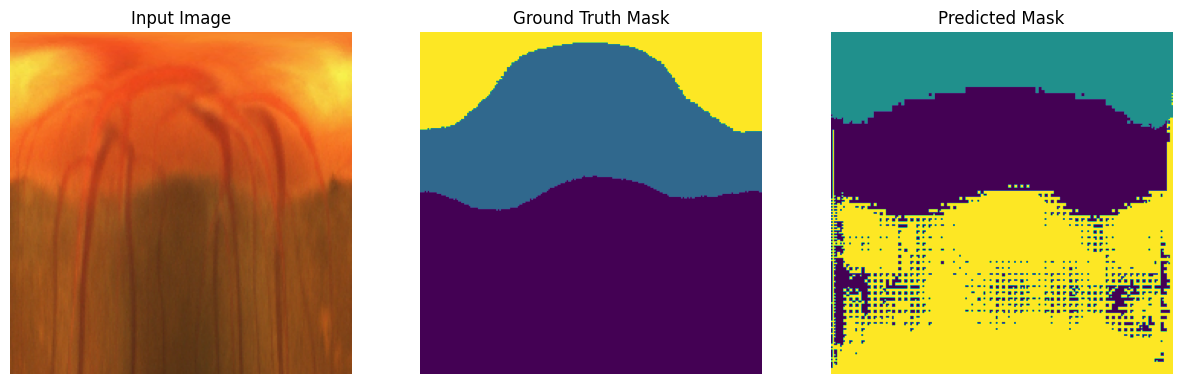

In [9]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    # Load and preprocess the image
    img = np.asarray(image.load_img(
        img_path,
        target_size=(target_size, target_size, 3))
    ).astype('float32')
    
    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale')
    
    img_mask = np.asarray(img_mask).astype('int32')
    
    return img, img_mask

# Select a sample from the validation set
sample_index = 0
sample_img_name = val_list[sample_index]
sample_mask_name = val_list[sample_index]  # Assuming mask filenames are the same as image filenames

sample_img_path = os.path.join(val_data_path, sample_img_name)
sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

print(sample_img_name)
print(sample_mask_name)

# Load the image and mask
input_size = 224  # Ensure this matches your model's expected input size
img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict
predictions = origin_model.predict(img_input)
final_output = predictions[-1][0]  # Extract the first sample from the batch

# Since the model outputs softmax probabilities over 3 classes, take the argmax to get predicted class labels
predicted_mask = np.argmax(final_output, axis=-1)


# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img/255.0)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

Image: n0287_600.png
Mask: n0287_600.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


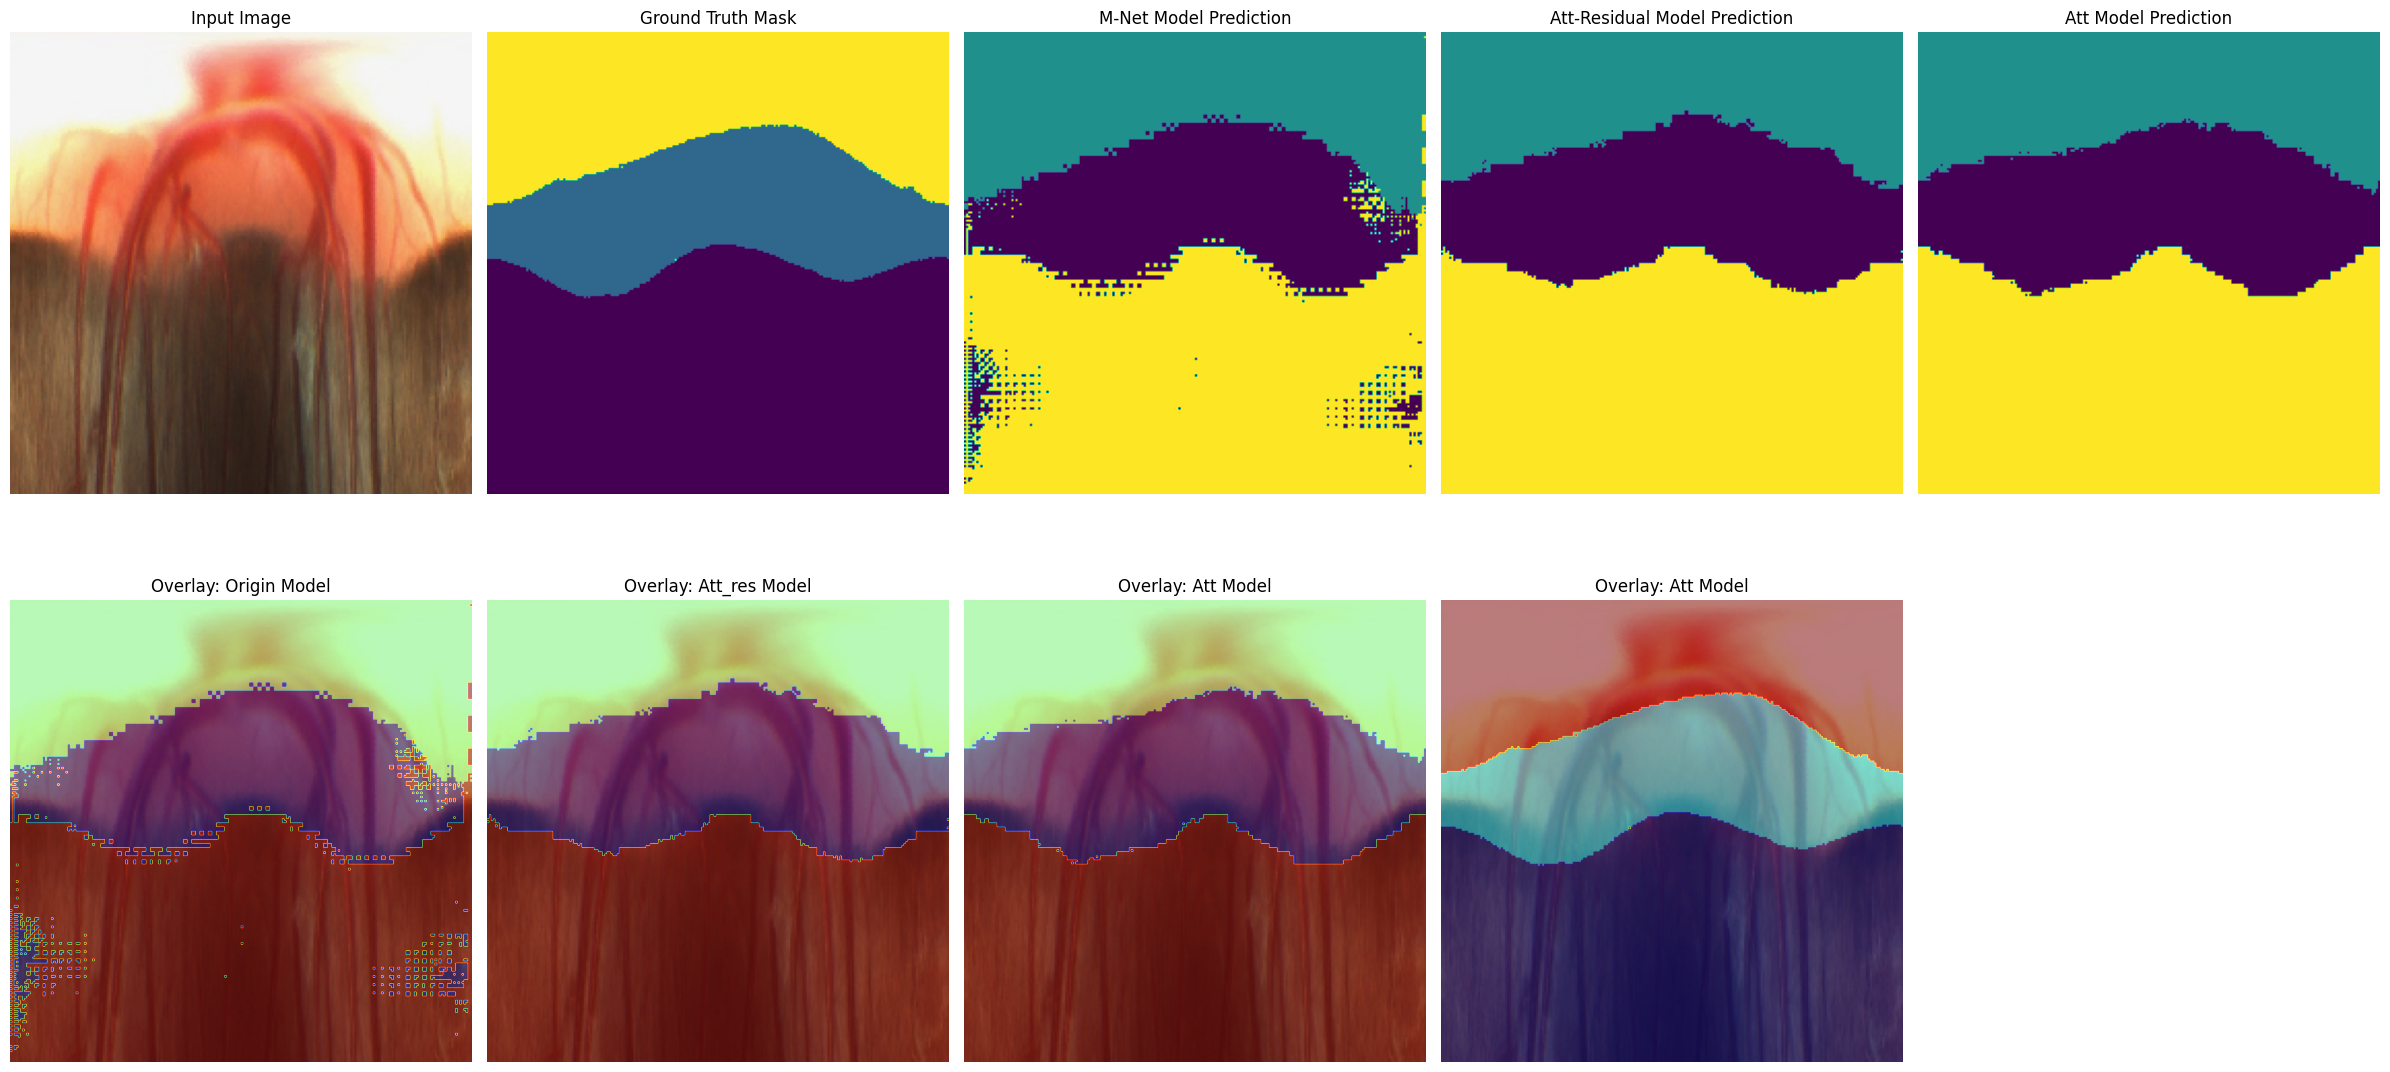

In [10]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Ensure all necessary imports are included
# If you haven't already, import your models
# from your_model_definitions import origin_model, Att_res_Model, Att_Model

# Function to load a single image and mask
def load_single_image(img_path, mask_path, target_size):
    """
    Loads and preprocesses an image and its corresponding mask.

    Parameters:
    - img_path (str): Path to the input image.
    - mask_path (str): Path to the ground truth mask.
    - target_size (int): Desired size to resize the image and mask.

    Returns:
    - img (np.array): Preprocessed input image.
    - img_mask (np.array): Preprocessed ground truth mask.
    """
    # Load and preprocess the image
    img = image.load_img(
        img_path,
        target_size=(target_size, target_size),
        color_mode='rgb'  # Ensure image has 3 channels
    )
    img = np.asarray(img).astype('float32')  # Normalize to [0, 1]

    # Load and preprocess the mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale'  # Masks are usually single-channel
    )
    img_mask = np.asarray(img_mask).astype('int32')

    return img, img_mask

# Select a sample from the validation set
sample_index = 4 # Change as needed to select different samples
sample_img_name = val_list[sample_index]
sample_mask_name = val_list[sample_index]  # Adjust if mask filenames differ

sample_img_path = os.path.join(val_data_path, sample_img_name)
sample_mask_path = os.path.join(val_mask_path, sample_mask_name)

print(f"Image: {sample_img_name}")
print(f"Mask: {sample_mask_name}")

# Load the image and mask
input_size = 224  # Ensure this matches your model's expected input size
img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
img_input = np.expand_dims(img, axis=0)  # Add batch dimension

# Function to perform prediction and process the output
def get_predicted_mask(model, img_input):
    """
    Generates the predicted mask using the given model.

    Parameters:
    - model: Trained Keras model for prediction.
    - img_input (np.array): Preprocessed input image with batch dimension.

    Returns:
    - predicted_mask (np.array): The predicted mask after applying argmax.
    """
    predictions = model.predict(img_input)
    
    # Handle different model output structures
    # If your model returns multiple outputs, adjust accordingly
    if isinstance(predictions, list):
        # Assuming the last element in the list is the desired output
        final_output = predictions[-1][0]
    else:
        # Single output model
        final_output = predictions[0]
    
    # If the output shape is (height, width, num_classes), apply argmax
    if final_output.ndim == 3:
        predicted_mask = np.argmax(final_output, axis=-1)
    else:
        # Handle other possible output shapes if necessary
        predicted_mask = final_output
    
    return predicted_mask

# Predict with all three models
predicted_mask_origin = get_predicted_mask(origin_model, img_input)
predicted_mask_att_res = get_predicted_mask(Att_res_Model, img_input)
predicted_mask_att = get_predicted_mask(Att_Model, img_input)

# Visualization
plt.figure(figsize=(24, 12))

# Display Input Image
plt.subplot(2, 5, 1)
plt.imshow(img/255)
plt.title('Input Image')
plt.axis('off')

# Display Ground Truth Mask
plt.subplot(2, 5, 2)
plt.imshow(mask)
plt.title('Ground Truth Mask')
plt.axis('off')

# Display Origin Model Prediction
plt.subplot(2, 5, 3)
plt.imshow(predicted_mask_origin)
plt.title('M-Net Model Prediction')
plt.axis('off')

# Display Att_res_Model Prediction
plt.subplot(2, 5, 4)
plt.imshow(predicted_mask_att_res)
plt.title('Att-Residual Model Prediction')
plt.axis('off')

# Display Att_Model Prediction
plt.subplot(2, 5, 5)
plt.imshow(predicted_mask_att)
plt.title('Att Model Prediction')
plt.axis('off')

# Optionally, add more visual comparisons or overlays below
# For example, overlay predicted masks on the input image

# Example: Overlay Origin Model Prediction
plt.subplot(2, 5, 6)
plt.imshow(img/255)
plt.imshow(predicted_mask_origin, cmap='jet', alpha=0.5)
plt.title('Overlay: Origin Model')
plt.axis('off')

# Overlay Att_res_Model Prediction
plt.subplot(2, 5, 7)
plt.imshow(img/255)
plt.imshow(predicted_mask_att_res, cmap='jet', alpha=0.5)
plt.title('Overlay: Att_res Model')
plt.axis('off')

# Overlay Att_Model Prediction
plt.subplot(2, 5, 8)
plt.imshow(img/255)
plt.imshow(predicted_mask_att, cmap='jet', alpha=0.5)
plt.title('Overlay: Att Model')
plt.axis('off')

# Overlay Att_Model Prediction
plt.subplot(2, 5, 9)
plt.imshow(img/255)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.title('Overlay: Att Model')
plt.axis('off')


# Add a legend or colorbar if necessary
# Note: Adding a colorbar for multiple subplots can be complex. Consider adding it to one subplot.

plt.tight_layout()
plt.show()

In [11]:
def remap_mask_values(mask):
    """
    Remaps the original mask pixel values to discrete classes:
    - 0: Disc
    - 1: Cup
    - 2: Background

    Parameters:
    - mask (np.array): Original mask with pixel values.

    Returns:
    - remapped_mask (np.array): Mask with remapped class labels.
    """
    value_mapping = {
        0: 2,    # Background
        76: 0,   # Disc
        225: 1,
        226: 1   # Cup
    }
    
    # Default value for undefined keys
    default_value = 2  # Treat unexpected values as Background
    remapped_mask = np.vectorize(lambda x: value_mapping.get(x, default_value))(mask)
    
    return remapped_mask

# Function to calculate confusion matrix components for a given class
def calculate_class_confusion(predicted_mask, ground_truth_mask, target_class):
    """
    Calculates TP, TN, FP, FN for a specific class.

    Parameters:
    - predicted_mask (np.array): Predicted mask with class labels.
    - ground_truth_mask (np.array): Ground truth mask with class labels.
    - target_class (int): The class label for which to calculate confusion components.

    Returns:
    - TP (int): True Positives
    - TN (int): True Negatives
    - FP (int): False Positives
    - FN (int): False Negatives
    """
    # Flatten the arrays for comparison
    pred_flat = (predicted_mask == target_class).flatten().astype(int)
    gt_flat = (ground_truth_mask == target_class).flatten().astype(int)
    
    # Calculate confusion matrix components
    TP = np.sum((pred_flat == 1) & (gt_flat == 1))  # True Positives
    TN = np.sum((pred_flat == 0) & (gt_flat == 0))  # True Negatives
    FP = np.sum((pred_flat == 1) & (gt_flat == 0))  # False Positives
    FN = np.sum((pred_flat == 0) & (gt_flat == 1))  # False Negatives

    return TP, TN, FP, FN

# Function to calculate metrics given accumulated confusion components
def compute_metrics_from_confusion(TP, TN, FP, FN):
    """
    Computes Sensitivity, Specificity, Error, and Balanced Accuracy from confusion components.

    Parameters:
    - TP (int): True Positives
    - TN (int): True Negatives
    - FP (int): False Positives
    - FN (int): False Negatives

    Returns:
    - Sen (float): Sensitivity
    - Spe (float): Specificity
    - E (float): Error
    - A (float): Balanced Accuracy
    """
    Sen = TP / (TP + FN) if (TP + FN) > 0 else 0
    Spe = TN / (TN + FP) if (TN + FP) > 0 else 0

    # Overlap metrics
    intersection = TP  # Intersection is TP for binary classification
    union = TP + FP + FN
    E = 1 - (intersection / union) if union > 0 else 1  # Error
    A = 0.5 * (Sen + Spe)  # Balanced accuracy

    return Sen, Spe, E, A

# Function to calculate metrics over the whole validation set for multiple models
def calculate_metrics_over_validation(models_dict, val_list, val_data_path, val_mask_path, input_size=224):
    """
    Calculates performance metrics for multiple models over the validation set.

    Parameters:
    - models_dict (dict): Dictionary where keys are model names and values are the model instances.
    - val_list (list): List of validation image filenames.
    - val_data_path (str): Path to the validation images.
    - val_mask_path (str): Path to the validation masks.
    - input_size (int): The input size for the models.

    Returns:
    - all_metrics (dict): Nested dictionary containing metrics for each model and class.
    """
    # Classes: 0 (Disc), 1 (Cup), 2 (Background)
    class_labels = [0, 1, 2]
    
    # Initialize accumulators for each model and class
    all_accumulators = {
        model_name: {
            cls: {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
            for cls in class_labels
        }
        for model_name in models_dict.keys()
    }
    
    # Iterate over the entire validation set
    for i, img_name in enumerate(val_list):
        mask_name = img_name  # Assuming mask filenames are the same as image filenames
        sample_img_path = os.path.join(val_data_path, img_name)
        sample_mask_path = os.path.join(val_mask_path, mask_name)
        
        # Load the image and mask
        img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)  # Add batch dimension

        # Remap ground truth mask values
        ground_truth_mask = remap_mask_values(mask)

        # Predict with each model and accumulate confusion components
        for model_name, model in models_dict.items():
            predictions = model.predict(img_input)
            
            # Handle different model output structures
            if isinstance(predictions, list):
                # Assuming the last element in the list is the desired output
                final_output = predictions[-1][0]
            else:
                # Single output model
                final_output = predictions[0]
            
            # If the output shape is (height, width, num_classes), apply argmax
            if final_output.ndim == 3:
                predicted_mask = np.argmax(final_output, axis=-1)
            else:
                # Handle other possible output shapes if necessary
                predicted_mask = final_output

            # Accumulate confusion values for each class
            for cls in class_labels:
                TP, TN, FP, FN = calculate_class_confusion(predicted_mask, ground_truth_mask, cls)
                all_accumulators[model_name][cls]["TP"] += TP
                all_accumulators[model_name][cls]["TN"] += TN
                all_accumulators[model_name][cls]["FP"] += FP
                all_accumulators[model_name][cls]["FN"] += FN

        # Optional: Print progress every N samples
        if (i + 1) % 100 == 0 or (i + 1) == len(val_list):
            print(f"Processed {i + 1}/{len(val_list)} images.")

    # After processing the whole dataset, compute the final metrics
    all_metrics = {}
    for model_name, class_data in all_accumulators.items():
        all_metrics[model_name] = {}
        for cls, confusion in class_data.items():
            TP = confusion["TP"]
            TN = confusion["TN"]
            FP = confusion["FP"]
            FN = confusion["FN"]

            Sen, Spe, E, A = compute_metrics_from_confusion(TP, TN, FP, FN)
            all_metrics[model_name][f"Class {cls}"] = {
                "Sensitivity (Sen)": Sen,
                "Specificity (Spe)": Spe,
                "Error (E)": E,
                "Balanced Accuracy (A)": A,
                "TP": TP,
                "TN": TN,
                "FP": FP,
                "FN": FN
            }
    
    return all_metrics


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

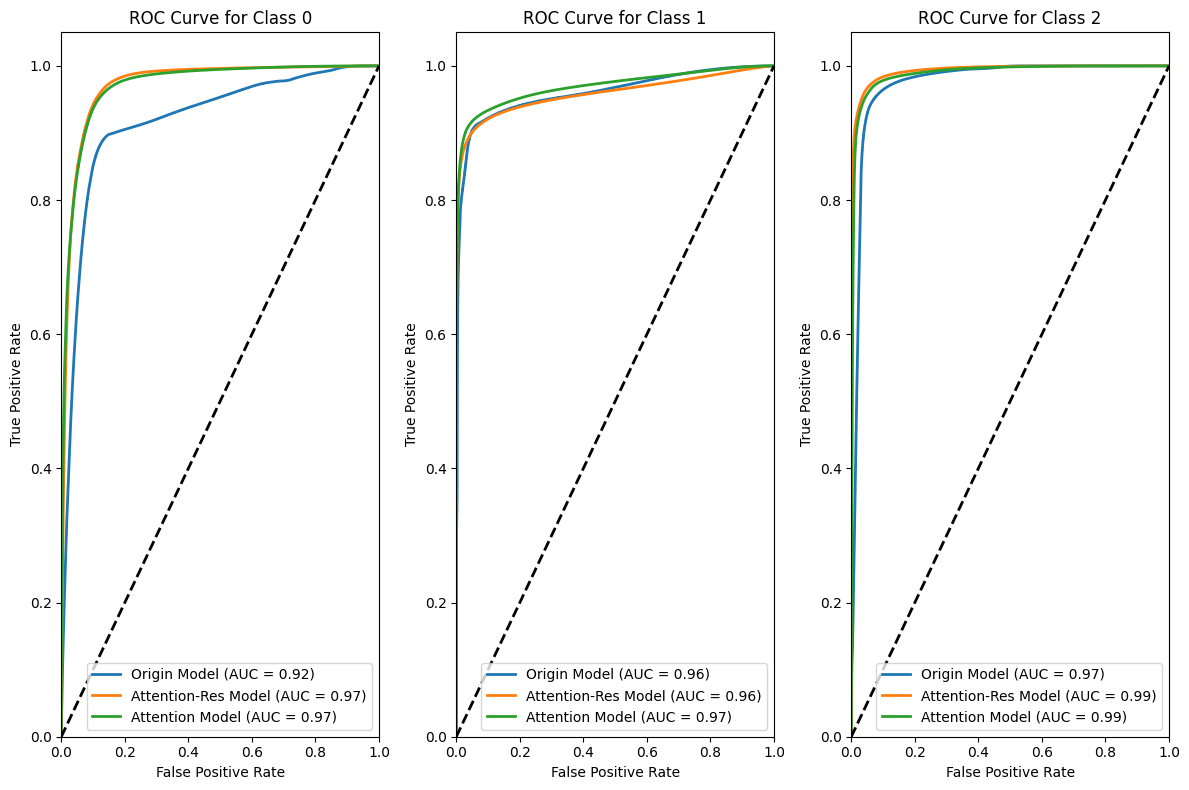

In [12]:
def calculate_metrics_over_validation(models_dict, val_list, val_data_path, val_mask_path, input_size=224):
    """
    Calculates performance metrics for multiple models over the validation set.

    Parameters:
    - models_dict (dict): Dictionary where keys are model names and values are the model instances.
    - val_list (list): List of validation image filenames.
    - val_data_path (str): Path to the validation images.
    - val_mask_path (str): Path to the validation masks.
    - input_size (int): The input size for the models.

    Returns:
    - all_metrics (dict): Nested dictionary containing metrics for each model and class.
    """
    # Classes: 0 (Disc), 1 (Cup), 2 (Background)
    class_labels = [0, 1, 2]
    
    # Initialize accumulators for each model and class
    all_accumulators = {
        model_name: {
            cls: {"TP": 0, "TN": 0, "FP": 0, "FN": 0}
            for cls in class_labels
        }
        for model_name in models_dict.keys()
    }
    
    # Initialize structure to store probabilities and labels for ROC
    roc_data = {
        model_name: {
            cls: {"y_true": [], "y_scores": []}
            for cls in class_labels
        }
        for model_name in models_dict.keys()
    }
    
    # Iterate over the entire validation set
    for i, img_name in enumerate(val_list):
        mask_name = img_name  # Assuming mask filenames are the same as image filenames
        sample_img_path = os.path.join(val_data_path, img_name)
        sample_mask_path = os.path.join(val_mask_path, mask_name)
        
        # Load the image and mask
        img, mask = load_single_image(sample_img_path, sample_mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)  # Add batch dimension

        # Remap ground truth mask values
        ground_truth_mask = remap_mask_values(mask)

        # Predict with each model and accumulate confusion components and ROC data
        for model_name, model in models_dict.items():
            predictions = model.predict(img_input)
            
            # Handle different model output structures
            if isinstance(predictions, list):
                # Assuming the last element in the list is the desired output
                final_output = predictions[-1][0]
            else:
                # Single output model
                final_output = predictions[0]
            
            # If the output shape is (height, width, num_classes), apply softmax if not already applied
            if final_output.ndim == 3:
                # Check if output is already probabilities
                if not np.allclose(np.sum(final_output, axis=-1), 1, atol=1e-2):
                    # Apply softmax
                    exp_preds = np.exp(final_output - np.max(final_output, axis=-1, keepdims=True))
                    probabilities = exp_preds / np.sum(exp_preds, axis=-1, keepdims=True)
                else:
                    probabilities = final_output
                predicted_mask = np.argmax(probabilities, axis=-1)
            else:
                # Handle other possible output shapes if necessary
                probabilities = final_output
                predicted_mask = final_output  # This might need adjustment based on model
            
            # Accumulate confusion values for each class
            for cls in class_labels:
                TP, TN, FP, FN = calculate_class_confusion(predicted_mask, ground_truth_mask, cls)
                all_accumulators[model_name][cls]["TP"] += TP
                all_accumulators[model_name][cls]["TN"] += TN
                all_accumulators[model_name][cls]["FP"] += FP
                all_accumulators[model_name][cls]["FN"] += FN

                # For ROC curve, collect true labels and predicted scores
                # Flatten the arrays and append
                y_true = (ground_truth_mask == cls).astype(int).flatten()
                y_scores = probabilities[..., cls].flatten()
                roc_data[model_name][cls]["y_true"].extend(y_true)
                roc_data[model_name][cls]["y_scores"].extend(y_scores)

        # Optional: Print progress every N samples
        if (i + 1) % 100 == 0 or (i + 1) == len(val_list):
            print(f"Processed {i + 1}/{len(val_list)} images.")

    # After processing the whole dataset, compute the final metrics
    all_metrics = {}
    for model_name, class_data in all_accumulators.items():
        all_metrics[model_name] = {}
        for cls, confusion in class_data.items():
            TP = confusion["TP"]
            TN = confusion["TN"]
            FP = confusion["FP"]
            FN = confusion["FN"]

            Sen, Spe, E, A = compute_metrics_from_confusion(TP, TN, FP, FN)
            all_metrics[model_name][f"Class {cls}"] = {
                "Sensitivity (Sen)": Sen,
                "Specificity (Spe)": Spe,
                "Error (E)": E,
                "Balanced Accuracy (A)": A,
                "TP": TP,
                "TN": TN,
                "FP": FP,
                "FN": FN
            }

    return all_metrics, roc_data

# Function to plot ROC curves
def plot_roc_curves(roc_data, class_labels=[0, 1, 2], model_names=None):
    """
    Plots ROC curves for multiple models and classes on the same plot.

    Parameters:
    - roc_data (dict): Nested dictionary containing y_true and y_scores for each model and class.
    - class_labels (list): List of class labels.
    - model_names (list): List of model names to plot. If None, all models in roc_data are plotted.
    """
    if model_names is None:
        model_names = list(roc_data.keys())
    
    # Define color cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray'])
    
    plt.figure(figsize=(12, 8))
    
    for cls in class_labels:
        plt.subplot(1, len(class_labels), cls+1)
        for model_name, cls_data in roc_data.items():
            y_true = np.array(cls_data[cls]["y_true"])
            y_scores = np.array(cls_data[cls]["y_scores"])
            
            # Compute ROC curve and ROC area
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for Class {cls}')
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

models_dict = {
    "Origin Model": origin_model,
    "Attention-Res Model": Att_res_Model,
    "Attention Model": Att_Model
}

# Calculate metrics for all models and collect ROC data
all_metrics, roc_data = calculate_metrics_over_validation(
    models_dict=models_dict,
    val_list=val_list,
    val_data_path=val_data_path,
    val_mask_path=val_mask_path,
    input_size=224  # Ensure this matches your model's expected input size
)

# Display the metrics in a structured format
for model_name, classes in all_metrics.items():
    print(f"\n=== Metrics for {model_name} ===")
    for cls, metrics in classes.items():
        print(f"\nMetrics for Class {cls}:")
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")

from itertools import cycle
from sklearn.metrics import roc_curve, auc

plot_roc_curves(roc_data, class_labels=[0, 1, 2], model_names=list(models_dict.keys()))

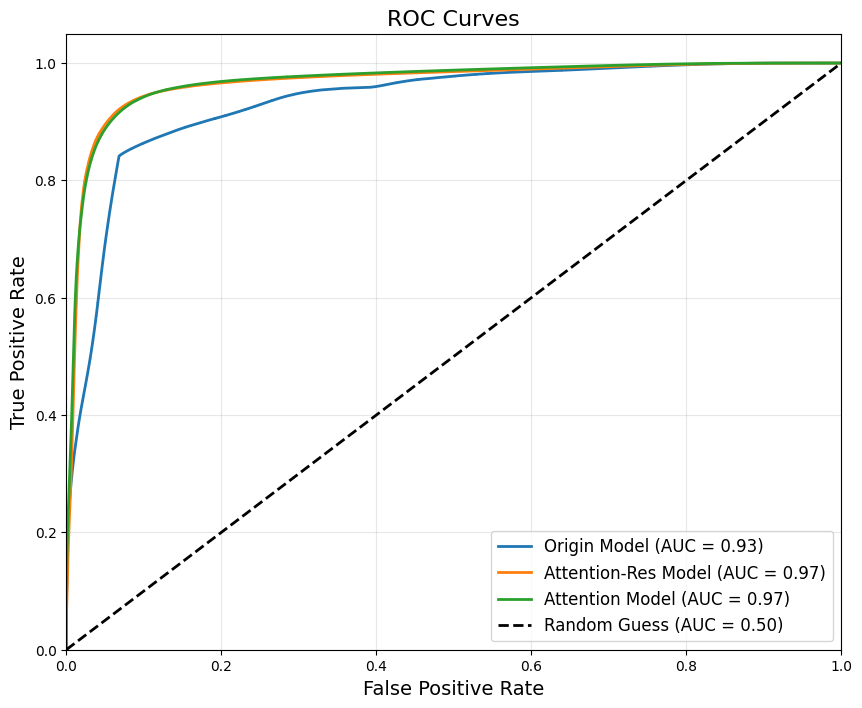

In [13]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

def plot_micro_average_roc_multi_models(roc_data, num_classes, model_names=None):
    """
    Plots micro-average ROC curves for multiple models on the same plot.

    Parameters:
    - roc_data (dict): Nested dictionary containing y_true and y_scores for each model and class.
    - num_classes (int): Number of classes.
    - model_names (list): List of model names to plot. If None, all models in roc_data are plotted.
    """
    if model_names is None:
        model_names = list(roc_data.keys())
    
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray'])

    for model_name in model_names:
        # Aggregate y_true and y_scores across all classes for micro-average
        y_true = []
        y_scores = []
        for cls in range(num_classes):
            y_true.extend(roc_data[model_name][cls]["y_true"])
            y_scores.extend(roc_data[model_name][cls]["y_scores"])
        
        y_true = np.array(y_true)
        y_scores = np.array(y_scores)
        
        # Compute ROC curve and AUC for micro-average
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.50)')
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

plot_micro_average_roc_multi_models(roc_data, num_classes=3, model_names=list(models_dict.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

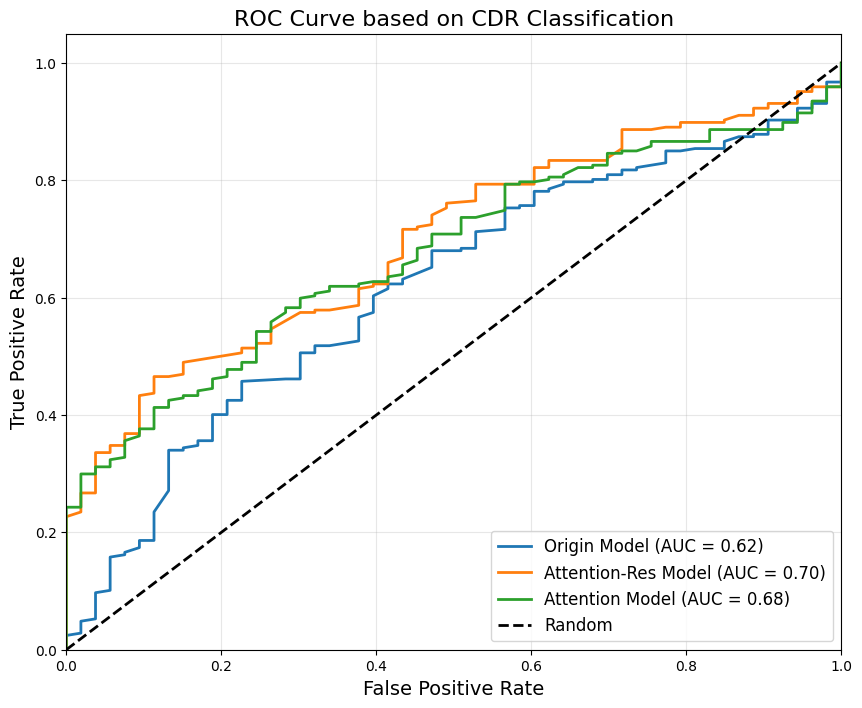

In [14]:
def compute_vertical_extent(mask, target_class):
    """
    Compute the vertical extent of the largest connected region for the given class in the mask.
    mask: 2D array of predicted classes
    target_class: the class label for disc (0) or cup (1)
    """
    # Extract binary mask for the target_class
    binary_mask = (mask == target_class)
    
    # Label connected components
    labeled = label(binary_mask)
    regions = regionprops(labeled)
    
    if len(regions) == 0:
        return 0  # If no region, extent is 0
    
    # Find the largest region by area
    largest_region = max(regions, key=lambda r: r.area)
    
    # Vertical extent = max_row - min_row for that region
    minr, minc, maxr, maxc = largest_region.bbox
    vertical_extent = maxr - minr
    return vertical_extent

def compute_cdr_from_mask(mask):
    """
    Compute CDR from a given mask array.
    Classes: 0 (Disc), 1 (Cup), 2 (Background)
    """
    disc_extent = compute_vertical_extent(mask, 0)  # Disc class
    cup_extent = compute_vertical_extent(mask, 1)   # Cup class
    
    if disc_extent == 0:
        return 0  # Avoid division by zero, if no disc predicted
    cdr = cup_extent / disc_extent
    return cdr

def remap_mask_values(mask):
    """
    Remaps the original mask pixel values to discrete classes:
    0: Disc, 1: Cup, 2: Background.
    """
    value_mapping = {
        0: 2,    # Background
        76: 0,   # Disc
        225: 1,
        226: 1   # Cup
    }
    
    # Default value for undefined keys
    default_value = 2  # Treat unexpected values as Background
    remapped_mask = np.vectorize(lambda x: value_mapping.get(x, default_value))(mask)
    return remapped_mask

def load_single_image(img_path, mask_path, target_size):
    # Load image
    img = image.load_img(
        img_path,
        target_size=(target_size, target_size),
        color_mode='rgb'
    )
    img = np.asarray(img).astype('float32')

    # Load mask
    img_mask = image.load_img(
        mask_path,
        target_size=(target_size, target_size),
        color_mode='grayscale'
    )
    img_mask = np.asarray(img_mask).astype('int32')
    return img, img_mask

def compute_cdr_labels_and_scores(models_dict, val_list, val_data_path, val_mask_path, input_size=224, cdr_threshold=0.7):
    """
    Compute ground truth labels (based on CDR) and predicted scores (predicted CDR) for each image.
    """
    # We'll store results for each model separately
    results = {model_name: {"y_true": [], "y_score": []} for model_name in models_dict.keys()}
    
    for i, img_name in enumerate(val_list):
        mask_name = img_name
        img_path = os.path.join(val_data_path, img_name)
        mask_path = os.path.join(val_mask_path, mask_name)
        
        img, mask = load_single_image(img_path, mask_path, input_size)
        img_input = np.expand_dims(img, axis=0)
        
        # Compute ground truth CDR
        gt_mask = remap_mask_values(mask)
        gt_cdr = compute_cdr_from_mask(gt_mask)
        # Ground truth binary label
        gt_label = 1 if gt_cdr > cdr_threshold else 0
        
        for model_name, model in models_dict.items():
            predictions = model.predict(img_input)
            
            # Handle different model output structures
            if isinstance(predictions, list):
                final_output = predictions[-1][0]
            else:
                final_output = predictions[0]
                
            # Compute predicted mask
            predicted_mask = np.argmax(final_output, axis=-1)
            pred_cdr = compute_cdr_from_mask(predicted_mask)
            
            # Store results
            results[model_name]["y_true"].append(gt_label)
            results[model_name]["y_score"].append(pred_cdr)
        
        if (i+1) % 100 == 0 or (i+1) == len(val_list):
            print(f"Processed {i+1}/{len(val_list)} images.")
    
    return results

def plot_roc_cdr(results):
    """
    Plot ROC curve and compute AUC based on CDR for each model.
    """
    plt.figure(figsize=(10,8))
    
    for model_name, data in results.items():
        y_true = np.array(data["y_true"])
        y_score = np.array(data["y_score"])
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', lw=2)
        
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve based on CDR Classification', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:

# Assume you have defined:
# origin_model, Att_res_Model, Att_Model
# val_list, val_data_path, val_mask_path

models_dict = {
    "Origin Model": origin_model,
    "Attention-Res Model": Att_res_Model,
    "Attention Model": Att_Model
}

# Define a CDR threshold for classification
cdr_threshold = 0.7  # example threshold
results = compute_cdr_labels_and_scores(models_dict, val_list, val_data_path, val_mask_path, input_size=224, cdr_threshold=cdr_threshold)
plot_roc_cdr(results)